## Neural Network model evaluation
The evaluation dataset consists of 3486 logs that were retrieved from the single Elasticsearch index and two hosts:
- 100.64.192.76
- 10.190.102.176

Two attack attempts were made on host 10.190.102.176 (Metasploitable VM):
- SSH login brute-force attack
- MySQL login brute-force attack

In [437]:
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from solution.feature_extraction import FeatureExtraction
from solution.prediction import predict, prepare_test_df, plot_reconstruction_error
from solution.evaluation import get_fpr, get_tpr

df = pd.read_pickle("data.pkl")  # Data autoencoder was trained on
autoencoder = load_model("model1")  # Trained autoencoder model

### Testing data
Parse and preprocess data from Elasticsearch index:
- `test_df` data to analyze;
- `fe_alert_df` alerts that were raised in the same period - used for validation;
- `fe_val_df` original data (before processing), contains IP addresses / port numbers etc.

In [ ]:
index_name = "so-ids-2023.05.08"

fe = FeatureExtraction([index_name], 10000)

test_df = fe.parse_logs(
    get_dataset_alert=True,
    additional_must_query=[
        {
            "range": {
                "@timestamp": {
                    "gte": "2023-05-08T10:45:00.000",
                    "lte": "2023-05-08T11:15:00.000",
                }
            }
        }
    ],
)
fe_val_df = fe.get_validation_dataframe(test_df)
fe_alert_df = fe.get_alert_dataset(test_df)

test_df = fe.preprocess_dataframe(test_df)  # Preprocess input data
test_df = prepare_test_df(test_df, df)  # Adjust shape

### Alerts validation
Suricata is able to detect two attacks that were made. By checking port numbers we can identify alerts:
- 3306 for MySQL attack
- 22 for FTP attack

Rules that were triggered in this period:
- ET SCAN Suspicious inbound to mySQL port 3306
- ET SCAN Multiple MySQL Login Failures Possible Brute Force Attempt
- ET SCAN Potential SSH Scan
- ET SCAN Potential SSH Scan OUTBOUND

In [459]:
fe_alert_df.loc[
    (fe_alert_df.src_port.isin((22, 3306))) | (fe_alert_df.dst_port.isin((22, 3306)))
]

,dataset,src_ip,src_port,dst_ip,dst_port,protocol,transport,src_country_name,dst_country_name,conn_state,...,dns_query_name,dns_query_type,dns_response_code,http_request_method,http_body_length,http_status_code,http_status_message,file_size,file_source,ssh_client
15793,alert,100.64.192.76,41391.0,10.190.102.176,22.0,None,TCP,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15794,alert,100.64.192.76,41391.0,10.190.102.176,22.0,None,TCP,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15795,alert,100.64.192.76,41741.0,10.190.102.176,22.0,None,TCP,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15796,alert,100.64.192.76,38069.0,10.190.102.176,22.0,None,TCP,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15797,alert,100.64.192.76,44271.0,10.190.102.176,22.0,None,TCP,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15857,alert,10.190.102.176,3306.0,100.64.192.76,58154.0,None,TCP,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15858,alert,10.190.102.176,3306.0,100.64.192.76,38000.0,None,TCP,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15859,alert,10.190.102.176,3306.0,100.64.192.76,38018.0,None,TCP,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15860,alert,10.190.102.176,3306.0,100.64.192.76,38030.0,None,TCP,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Labels
Anomaly labels are extracted from `fe_alert_df` by analyzing combinations of source and destination IP adresses.

In [479]:
# Column indicates whether the row index is anomalous or not
test_df["is_anomaly"] = False

# Extract unique (src_ip, dst_ip) combinations
groups = fe_alert_df.groupby(["src_ip", "dst_ip"])

# Extract unique pairs
ip_list = [group_name for group_name, _ in groups]
ip_set_list = [set(pair) for pair in ip_list]

# Label anomalous row indices using the mask
mask = fe_val_df.apply(lambda x: set([x["src_ip"], x["dst_ip"]]) in ip_set_list, axis=1)
test_df.loc[fe_val_df[mask].index, "is_anomaly"] = True

# Extract is_anomaly column from dataframe
labels = test_df["is_anomaly"].to_numpy()
test_df.drop("is_anomaly", axis=1, inplace=True)

print("Evaluation dataframe size: ", test_df.shape)
print("Number of normal logs: ", labels[labels == False].size)
print("Number of anomalies: ", labels[labels == True].size)

Evaluation dataframe size:  (15793, 139)
Number of normal logs:  15613
Number of anomalies:  180


In [482]:
# Calculate the reconstruction error for testing data

reconstruction_error = predict(autoencoder, test_df)

494/494 [==============================] - 2s 4ms/step


## Evaluation

### ROC (Receiver operating characteristic) curve
- true positive rate (TPR) against the false positive rate (FPR) for different threshold values

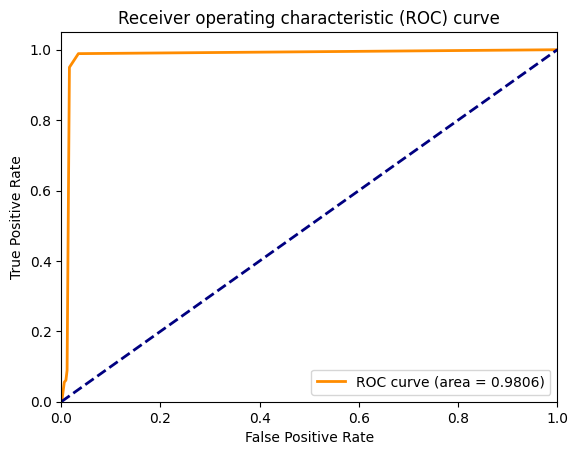

In [483]:
from sklearn.metrics import auc

thresholds = np.arange(0, 1, 0.01)
tprs = []
fprs = []
for thresh in thresholds:
    # Compute true positive rate and false positive rate for a given threshold
    preds = reconstruction_error > thresh
    tpr = get_tpr(preds, labels)
    fpr = get_fpr(preds, labels)

    tprs.append(tpr)
    fprs.append(fpr)

auc_score = auc(fprs, tprs)

# Plot ROC curve
plt.plot(
    fprs, tprs, color="darkorange", lw=2, label=f"ROC curve (area = {auc_score:.4f})"
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC) curve")
plt.legend(loc="lower right")
plt.show()

### Evaluation metrics

- Accuracy
- Precision
- Recall
- F1 score

The best value for a threshold is determined based on F1 score.


In [484]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get best threshold based on f1 scores for each threshold value
maxf1 = 0
ttreshold = 0
for thresh in thresholds:
    preds = reconstruction_error > thresh
    f1 = f1_score(labels, preds)
    if f1 > maxf1:
        maxf1 = f1
        ttreshold = thresh

print(f"Best performance threshold: {ttreshold}\n")

# Calculate evaluation metrics
preds = reconstruction_error > ttreshold
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

Best performance threshold: 0.02

Accuracy: 0.983220414107516
Precision: 0.40046838407494145
Recall: 0.95
F1 score: 0.5634266886326194


Threshold value: 0.02


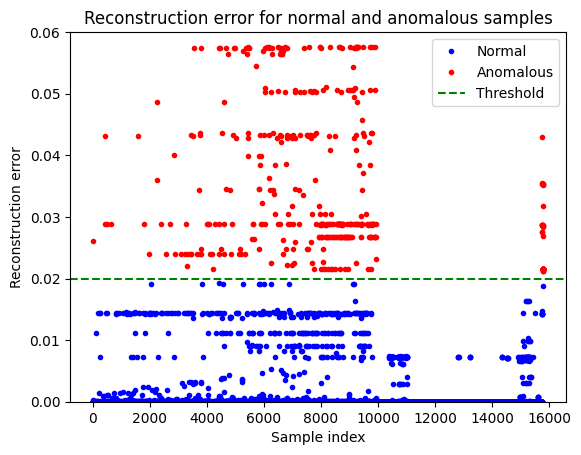

In [486]:
# First threshold gave the best results in terms of TPR and FPR

print(f"Threshold value: {ttreshold}")
plot_reconstruction_error(reconstruction_error, ttreshold, (0, 0.06))